# Forecast - Prophet

## Libraries and Data

In [ ]:
# Libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:
# Data
df = pd.read_csv('../Data/nyc-data.csv')
future_df = pd.read_csv('../Data/future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [ ]:
# Merge datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop=True)
df

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...,...
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752


In [ ]:
# Rename variables for Prophet
df = df.rename(columns={'Demand': 'y',
                        'Date': 'ds'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305


In [ ]:
# Convert date variable
df.ds = pd.to_datetime(df.ds,
                       format='%m/%d/%Y')
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305


## Holidays

In [ ]:
# Funciton for holidays dataframe
def make_holidays_df(df, holiday_dict):
  '''
  Makes the holidays dataframe used with Prophet.

  Parameters
  df: The DataFrame of time-series data.

  holiday_dict: A 3D dictionary for each holiday with the 'name',
  'lower_window', and 'upper_window' to be used in the returned DataFrame.
  '''
  holidays = pd.DataFrame()

  for holiday, dictionary in holiday_dict.items():
    # Get dates
    dates = pd.to_datetime(df[df[holiday] == 1].ds)

    # Create holiday df
    holiday_df = pd.DataFrame({'holiday': dictionary['name'],
                               'ds': dates,
                               'lower_window': dictionary['lower_window'],
                               'upper_window': dictionary['upper_window']})

    # Combine holidays df
    holidays = pd.concat([holidays, holiday_df])

  return holidays

In [ ]:
# Holiday parameters
holiday_dict = {'Easter': {'name': 'easter',
                           'lower_window': -5,
                           'upper_window': 2},
                'Thanksgiving': {'name': 'thanksgiving',
                                 'lower_window': -3,
                                 'upper_window': 6}}

In [ ]:
# Make holidays dataframe
holidays = make_holidays_df(df, holiday_dict)
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [ ]:
# Drop holidays from main dataframe
df = df.drop(columns=['Easter', 'Thanksgiving'])
df.head(2)

,ds,y,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,3.68,41.305
1,2015-01-02,581.276773,0,4.73,131.574


In [ ]:
# Split the data again
training = df.iloc[:-31, :]
future_df = df.iloc[-31:, :]
len(training) + len(future_df)

2223

In [ ]:
# Fetch the parameters
parameters = pd.read_csv('best-params-prophet.csv',
                          index_col=0)
parameters

,57
changepoint_prior_scale,0.01
holidays_prior_scale,25
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.042216320437696


In [ ]:
# Extract the values
changepoint_prior_scale = float(parameters.loc['changepoint_prior_scale'][0])
holidays_prior_scale = float(parameters.loc['holidays_prior_scale'][0])
seasonality_prior_scale = float(parameters.loc['seasonality_prior_scale'][0])
seasonality_mode = parameters.loc['seasonality_mode'][0]

## Prophet Model

In [ ]:
# Prophet model
m = Prophet(holidays=holidays,
            seasonality_mode=seasonality_mode,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprzfmnf4c/4qajkc2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprzfmnf4c/_ika6j4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83416', 'data', 'file=/tmp/tmprzfmnf4c/4qajkc2t.json', 'init=/tmp/tmprzfmnf4c/_ika6j4l.json', 'output', 'file=/tmp/tmprzfmnf4c/prophet_modelmx_wr4os/prophet_model-20230804202611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Forecasting

In [ ]:
# Make future dataframe
future = m.make_future_dataframe(periods=len(future_df),
                                 freq='D')  # W for weekly, M for monthly
future = pd.concat([future, df.iloc[:, 2:]], axis=1)
future

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077
...,...,...,...,...
2218,2021-01-27,0,3.33,39.664
2219,2021-01-28,0,1.67,195.314
2220,2021-01-29,0,-2.78,235.894
2221,2021-01-30,0,1.11,152.752


In [ ]:
# Forecasting
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,595.798727,618.398496,760.719611,595.798727,595.798727,0.0,0.0,0.0,-3.423365,...,-4.044695,-4.044695,-4.044695,90.177958,90.177958,90.177958,0.0,0.0,0.0,689.274527
1,2015-01-02,595.912852,533.466508,672.740099,595.912852,595.912852,0.0,0.0,0.0,0.196414,...,-89.441138,-89.441138,-89.441138,88.805549,88.805549,88.805549,0.0,0.0,0.0,605.242089
2,2015-01-03,596.026977,646.976791,787.305871,596.026977,596.026977,0.0,0.0,0.0,1.444563,...,25.269323,25.269323,25.269323,87.598156,87.598156,87.598156,0.0,0.0,0.0,717.732458
3,2015-01-04,596.141102,566.602523,700.607834,596.141102,596.141102,0.0,0.0,0.0,1.347562,...,-55.621269,-55.621269,-55.621269,86.574901,86.574901,86.574901,0.0,0.0,0.0,632.292274
4,2015-01-05,596.255227,692.172649,832.878506,596.255227,596.255227,0.0,0.0,0.0,-3.031508,...,74.326135,74.326135,74.326135,85.749317,85.749317,85.749317,0.0,0.0,0.0,760.987107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,2021-01-27,702.063585,832.820025,970.191332,701.953449,702.210840,0.0,0.0,0.0,-3.489169,...,103.288131,103.288131,103.288131,88.396859,88.396859,88.396859,0.0,0.0,0.0,901.357804
2219,2021-01-28,701.639851,734.034717,868.393491,701.512281,701.837656,0.0,0.0,0.0,2.752382,...,-4.044695,-4.044695,-4.044695,87.331721,87.331721,87.331721,0.0,0.0,0.0,800.354639
2220,2021-01-29,701.216117,653.605676,788.058476,701.072932,701.431705,0.0,0.0,0.0,4.379636,...,-89.441138,-89.441138,-89.441138,86.095363,86.095363,86.095363,0.0,0.0,0.0,719.152810
2221,2021-01-30,700.792383,759.602797,891.756506,700.624772,701.037336,0.0,0.0,0.0,1.045650,...,25.269323,25.269323,25.269323,84.704147,84.704147,84.704147,0.0,0.0,0.0,825.018876


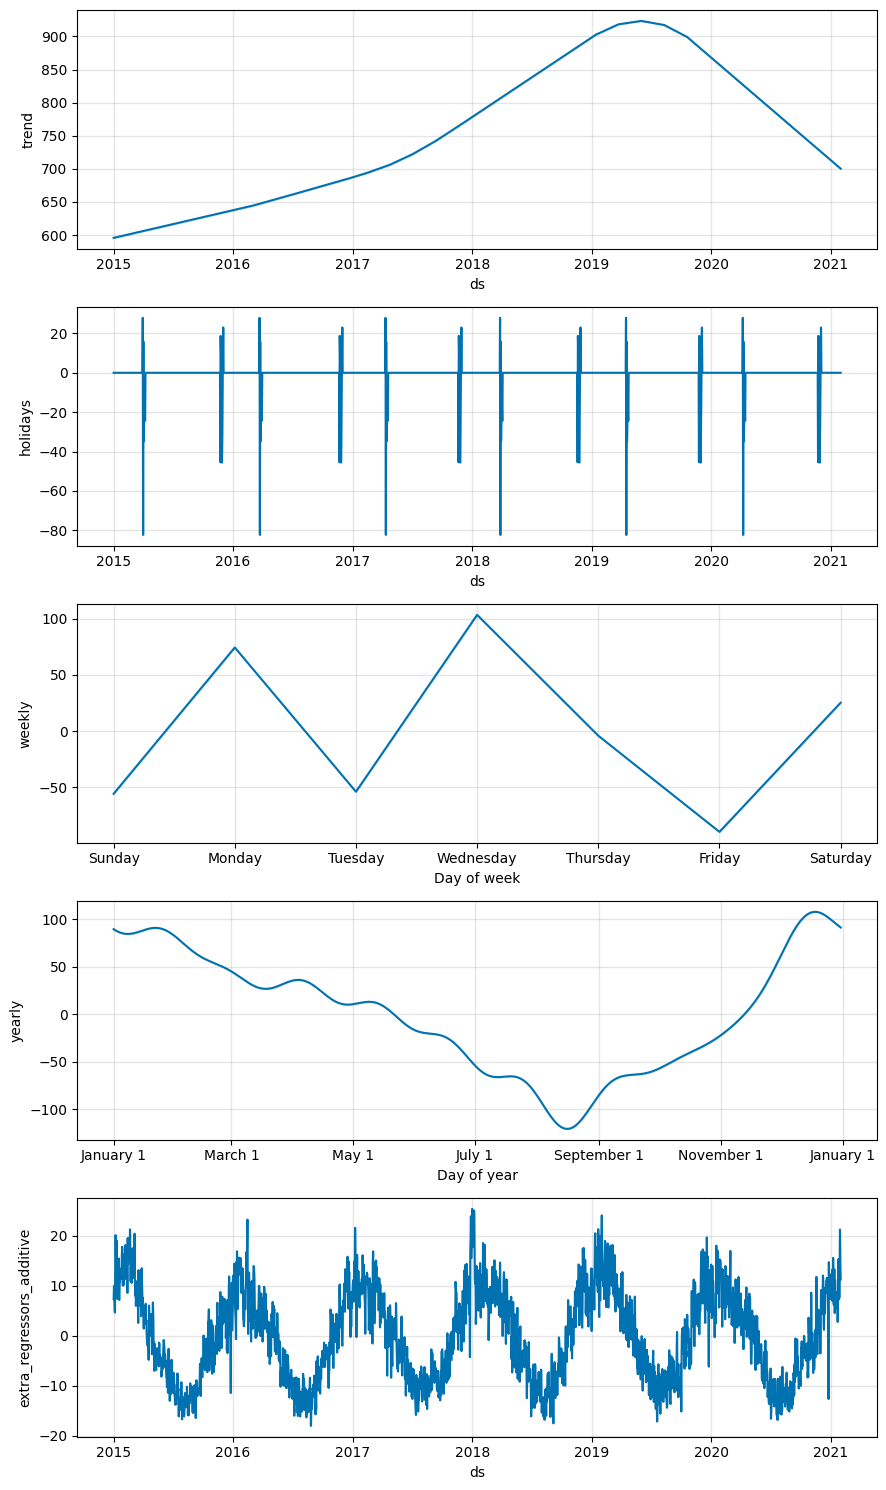

In [ ]:
# Plotting
m.plot_components(forecast);

In [ ]:
# Extract the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename('prophet')
predictions_prophet.index = future_df['ds']
predictions_prophet

In [ ]:
# Export
predictions_prophet.to_csv('Ensemble/predictions-prophet.csv')